# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Data-preprocessing" data-toc-modified-id="Data-preprocessing-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data preprocessing</a></div><div class="lev1 toc-item"><a href="#Compute-variogram" data-toc-modified-id="Compute-variogram-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Compute variogram</a></div><div class="lev1 toc-item"><a href="#Fit-residuals" data-toc-modified-id="Fit-residuals-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Fit residuals</a></div>

In [1]:
using DataFrames
using StatsBase
using GaussianProcesses
using Distances
using Distributions

In [2]:
import PyPlot; plt=PyPlot
plt.rc("figure", dpi=300.0)
# plt.rc("figure", figsize=(6,4))
# plt.rc("figure", autolayout=true)
plt.rc("savefig", dpi=300.0)
# plt.rc("text", usetex=true)
# plt.rc("font", family="serif")
# plt.rc("font", serif="Palatino")
;

# Data preprocessing

In [3]:
NYC_sales=readtable("NYC_data/processed/NYC_sales.csv", header=true)
# categorical variables
categorical!(NYC_sales, [:BOROUGH,
    :BUILDING_CLASS_CATEGORY,
    :BUILDING_CLASS_AT_TIME_OF_SALE,
    :ZIP_CODE,
    :TAX_CLASS_AT_PRESENT,
    :TAX_CLASS_AT_TIME_OF_SALE,
    :NEIGHBORHOOD,
    ])   

In [4]:
residential = Dict(
"01  ONE FAMILY DWELLINGS"=>true,
"02  TWO FAMILY DWELLINGS"=>true,
"03  THREE FAMILY DWELLINGS"=>true,
"04  TAX CLASS 1 CONDOS"=>true,
"05  TAX CLASS 1 VACANT LAND"=>false,
"06  TAX CLASS 1 - OTHER"=>false,
"07  RENTALS - WALKUP APARTMENTS"=>false,
"08  RENTALS - ELEVATOR APARTMENTS"=>false,
"09  COOPS - WALKUP APARTMENTS"=>true,
"10  COOPS - ELEVATOR APARTMENTS"=>true,
"11  SPECIAL CONDO BILLING LOTS"=>false,
"11A CONDO-RENTALS"=>false,
"12  CONDOS - WALKUP APARTMENTS"=>true, # why are these duplicated?
"13  CONDOS - ELEVATOR APARTMENTS"=>true,
"14  RENTALS - 4-10 UNIT"=>false,
"15  CONDOS - 2-10 UNIT RESIDENTIAL"=>true,
"16  CONDOS - 2-10 UNIT WITH COMMERCIAL UNIT"=>false,
"17  CONDO COOPS"=>true,
"18  TAX CLASS 3 - UNTILITY PROPERTIES"=>false,
"21  OFFICE BUILDINGS"=>false,
"22  STORE BUILDINGS"=>false,
"23  LOFT BUILDINGS"=>false,
"25  LUXURY HOTELS"=>false,
"26  OTHER HOTELS"=>false,
"27  FACTORIES"=>false,
"28  COMMERCIAL CONDOS"=>false,
"29  COMMERCIAL GARAGES"=>false,
"30  WAREHOUSES"=>false,
"31  COMMERCIAL VACANT LAND"=>false,
"32  HOSPITAL AND HEALTH FACILITIES"=>false,
"33  EDUCATIONAL FACILITIES"=>false,
"34  THEATRES"=>false,
"35  INDOOR PUBLIC AND CULTURAL FACILITIES"=>false,
"36  OUTDOOR RECREATIONAL FACILITIES"=>false,
"37  RELIGIOUS FACILITIES"=>false,
"38  ASYLUMS AND HOMES"=>false,
"41  TAX CLASS 4 - OTHER"=>false,
"42  CONDO CULTURAL/MEDICAL/EDUCATIONAL/ETC"=>false,
"43  CONDO OFFICE BUILDINGS"=>false,
"44  CONDO PARKING"=>false,
"45  CONDO HOTELS"=>false,
"46  CONDO STORE BUILDINGS"=>false,
"47  CONDO NON-BUSINESS STORAGE"=>false,
"48  CONDO TERRACES/GARDENS/CABANAS"=>false,
"49  CONDO WAREHOUSES/FACTORY/INDUS"=>false,
);

In [5]:
NYC_sales[:logSalePricePerSQFT] = map(log, NYC_sales[:SALE_PRICE]; lift=true) .- map(log, NYC_sales[:GROSS_SQUARE_FEET]; lift=true)
believable = zeros(Bool, size(NYC_sales,1))
removed=zeros(Int, 12)
for i in 1:size(NYC_sales,1)
    if NYC_sales[i,:SALE_PRICE].isnull
        removed[1] += 1
        continue
    end
    if NYC_sales[i,:SchDistr].isnull
        removed[2] += 1
        continue
    end
    if NYC_sales[i,:BUILDING_CLASS_AT_TIME_OF_SALE].isnull
        removed[3] += 1
        continue
    end
    if NYC_sales[i,:BUILDING_CLASS_CATEGORY].isnull
        removed[4] += 1
        continue
    end
    if !residential[get(NYC_sales[i,:BUILDING_CLASS_CATEGORY])]
        removed[5] += 1
        continue
    end
    if NYC_sales[i,:BUILDING_CLASS_CATEGORY].isnull
        removed[6] += 1
        continue
    end
    if NYC_sales[i,:TAX_CLASS_AT_TIME_OF_SALE].isnull
        removed[7] += 1
        continue
    end
    if NYC_sales[i,:GROSS_SQUARE_FEET].isnull
        removed[8] += 1
        continue
    end
    if get(NYC_sales[i,:GROSS_SQUARE_FEET])<100.0
        # remove cupboards
        removed[9] += 1
        continue
    end
    if get(NYC_sales[i,:logSalePricePerSQFT]) < 3.0
        removed[10] += 1
        # that's too cheap
        continue
    end
    if get(NYC_sales[i,:logSalePricePerSQFT]) > 12.0
        removed[11] += 1
        # that's too expensive
        continue
    end
    if NYC_sales[i,:XCoord].isnull
        removed[12] += 1
        continue
    end
    if NYC_sales[i,:YCoord].isnull
        removed[13] += 1
        continue
    end
    believable[i] = true
end

nobsv_ = sum(believable)
for_mm = copy(NYC_sales[believable,:])
reordering = collect(1:nobsv_)
schdistrs = unique(for_mm[:,:SchDistr].values)
istart = 1
for name in schdistrs
    indices = find(for_mm[:SchDistr].values .== name)
    nobsv_schdistr = length(indices)
    iend = istart+nobsv_schdistr-1
    reordering[istart:iend,:] = indices
    istart = iend+1
end
for_mm = for_mm[reordering,:]
schdistr_indices = Dict{String,Vector{Int}}()
for name in schdistrs
    indices = find(for_mm[:SchDistr].values .== name)
    schdistr_indices[name] = indices
end
;
Y_dict=Dict{String, Vector{Float64}}()
X_dict=Dict{String, Array{Float64,2}}()
for name in schdistrs
    Y_dict[name] = for_mm[schdistr_indices[name], :logSalePricePerSQFT]
    X_dict[name] = for_mm[schdistr_indices[name],[:XCoord, :YCoord]]
end

In [37]:
NYC_sales[NYC_sales[:BOROUGH].==NYC_sales[:BOROUGH][1],:]

LoadError: MethodError: Cannot `convert` an object of type Nullable{Bool} to an object of type Bool
This may have arisen from a call to the constructor Bool(...),
since type constructors fall back to convert methods.

In [32]:
NYC_sales[NYC_sales[:SchDistr].values.=="2",:][100:end,:]

,x,BOROUGH,BUILDING_CLASS_CATEGORY,BUILDING_CLASS_AT_TIME_OF_SALE,TAX_CLASS_AT_TIME_OF_SALE,TAX_CLASS_AT_PRESENT,ADDRESS,BUILDING_CLASS_AT_PRESENT,ZIP_CODE,XCoord,YCoord,SchDistr,NEIGHBORHOOD,GROSS_SQUARE_FEET,SALE_PRICE,SALE_DATE,LAND_SQUARE_FEET,logSalePricePerSQFT
1,20517,"""Manhattan""","""09 COOPS - WALKUP APARTMENTS""","""C6""",2.0,"""2""","325 WEST 21ST STREET, 6",C6,10011,984087.0,210608.0,2,"""CHELSEA""",#NULL,352000.0,2015-09-17,#NULL,#NULL
2,20518,"""Manhattan""","""09 COOPS - WALKUP APARTMENTS""","""C6""",2.0,"""2""","325 WEST 21ST STREET, 19",C6,10011,984087.0,210608.0,2,"""CHELSEA""",#NULL,544000.0,2016-05-19,#NULL,#NULL
3,20519,"""Manhattan""","""09 COOPS - WALKUP APARTMENTS""","""C6""",2.0,"""2""","347 WEST 22ND STREET, 4",C6,10011,984042.0,210927.0,2,"""CHELSEA""",#NULL,2.15e6,2015-10-29,#NULL,#NULL
4,20520,"""Manhattan""","""09 COOPS - WALKUP APARTMENTS""","""C6""",2.0,"""2""","354 WEST 23RD STREET, 1A",C6,10011,984042.0,211046.0,2,"""CHELSEA""",#NULL,630000.0,2015-08-13,#NULL,#NULL
5,20521,"""Manhattan""","""09 COOPS - WALKUP APARTMENTS""","""C6""",2.0,"""2""","354 WEST 23RD STREET, GC",C6,10011,984042.0,211046.0,2,"""CHELSEA""",#NULL,940000.0,2016-06-29,#NULL,#NULL
6,20522,"""Manhattan""","""09 COOPS - WALKUP APARTMENTS""","""C6""",2.0,"""2""","356 WEST 23RD STREET, 3A",C6,10011,984021.0,211057.0,2,"""CHELSEA""",#NULL,750000.0,2015-10-22,#NULL,#NULL
7,20523,"""Manhattan""","""09 COOPS - WALKUP APARTMENTS""","""C6""",2.0,"""2""","356 WEST 23RD STREET, 1BC",C6,10011,984021.0,211057.0,2,"""CHELSEA""",#NULL,1.305e6,2016-01-28,#NULL,#NULL
8,20524,"""Manhattan""","""09 COOPS - WALKUP APARTMENTS""","""C6""",2.0,"""2""","214 WEST 16TH STREET, 4S",C6,10011,984326.0,208898.0,2,"""CHELSEA""",#NULL,530000.0,2016-03-24,#NULL,#NULL
9,20525,"""Manhattan""","""09 COOPS - WALKUP APARTMENTS""","""C6""",2.0,"""2""","228 WEST 16TH STREET, 3B",C6,10011,984173.0,208983.0,2,"""CHELSEA""",#NULL,459000.0,2015-10-19,#NULL,#NULL
10,20526,"""Manhattan""","""09 COOPS - WALKUP APARTMENTS""","""C6""",2.0,"""2""","227 WEST 16TH STREET, 1/2WF",C6,10011,984287.0,209099.0,2,"""CHELSEA""",#NULL,1.35e6,2015-12-15,#NULL,#NULL


In [6]:
println(removed)
println(sum(believable))

[0,0,0,0,9004,0,0,27401,0,784,0,113]
19513


![districts](NYC_plots/NYC_school_performances_croppped.png)

# Compute variogram

In [7]:
rx=extrema(for_mm[:XCoord].values)
ry=extrema(for_mm[:YCoord].values)
dist_span = √( (rx[2]-rx[1])^2+(ry[2]-ry[1])^2 )

156873.62291985226

In [10]:
nbins=20
histbins = StatsBase.histrange(0.0, 20000.0, nbins, :left)
nbins=length(histbins)

22

In [11]:
collect(histbins)[1:10]

10-element Array{Float64,1}:
    0.0
 1000.0
 2000.0
 3000.0
 4000.0
 5000.0
 6000.0
 7000.0
 8000.0
 9000.0

In [12]:
type Variogram
    bins::AbstractVector
    sqdiff_accum::AbstractVector{Float64}
    npairs::AbstractVector{Int}
end
function Variogram(X::Matrix, Y::Vector, bins::AbstractVector)
    p,n = size(X)
    nbins=length(bins)
    sqdiff_accum = zeros(Float64, nbins)
    npairs = zeros(Int, nbins)
    for i in 1:n
        for j in 1:i-1
            dist = GaussianProcesses.distij(Euclidean(), X, i, j, p)
            ibin = searchsortedlast(histbins, dist)
            sqdiff_accum[ibin] += (Y[i]-Y[j])^2
            npairs[ibin] += 1
        end
    end
    return Variogram(bins, sqdiff_accum, npairs)
end
variog(v::Variogram) = v.sqdiff_accum ./ (v.npairs.*2)

variog_dict = Dict{String,Variogram}()
for name in schdistrs
    X = X_dict[name]
    Y = Y_dict[name]
    v = Variogram(X', Y, histbins)
    variog_dict[name] = v
end

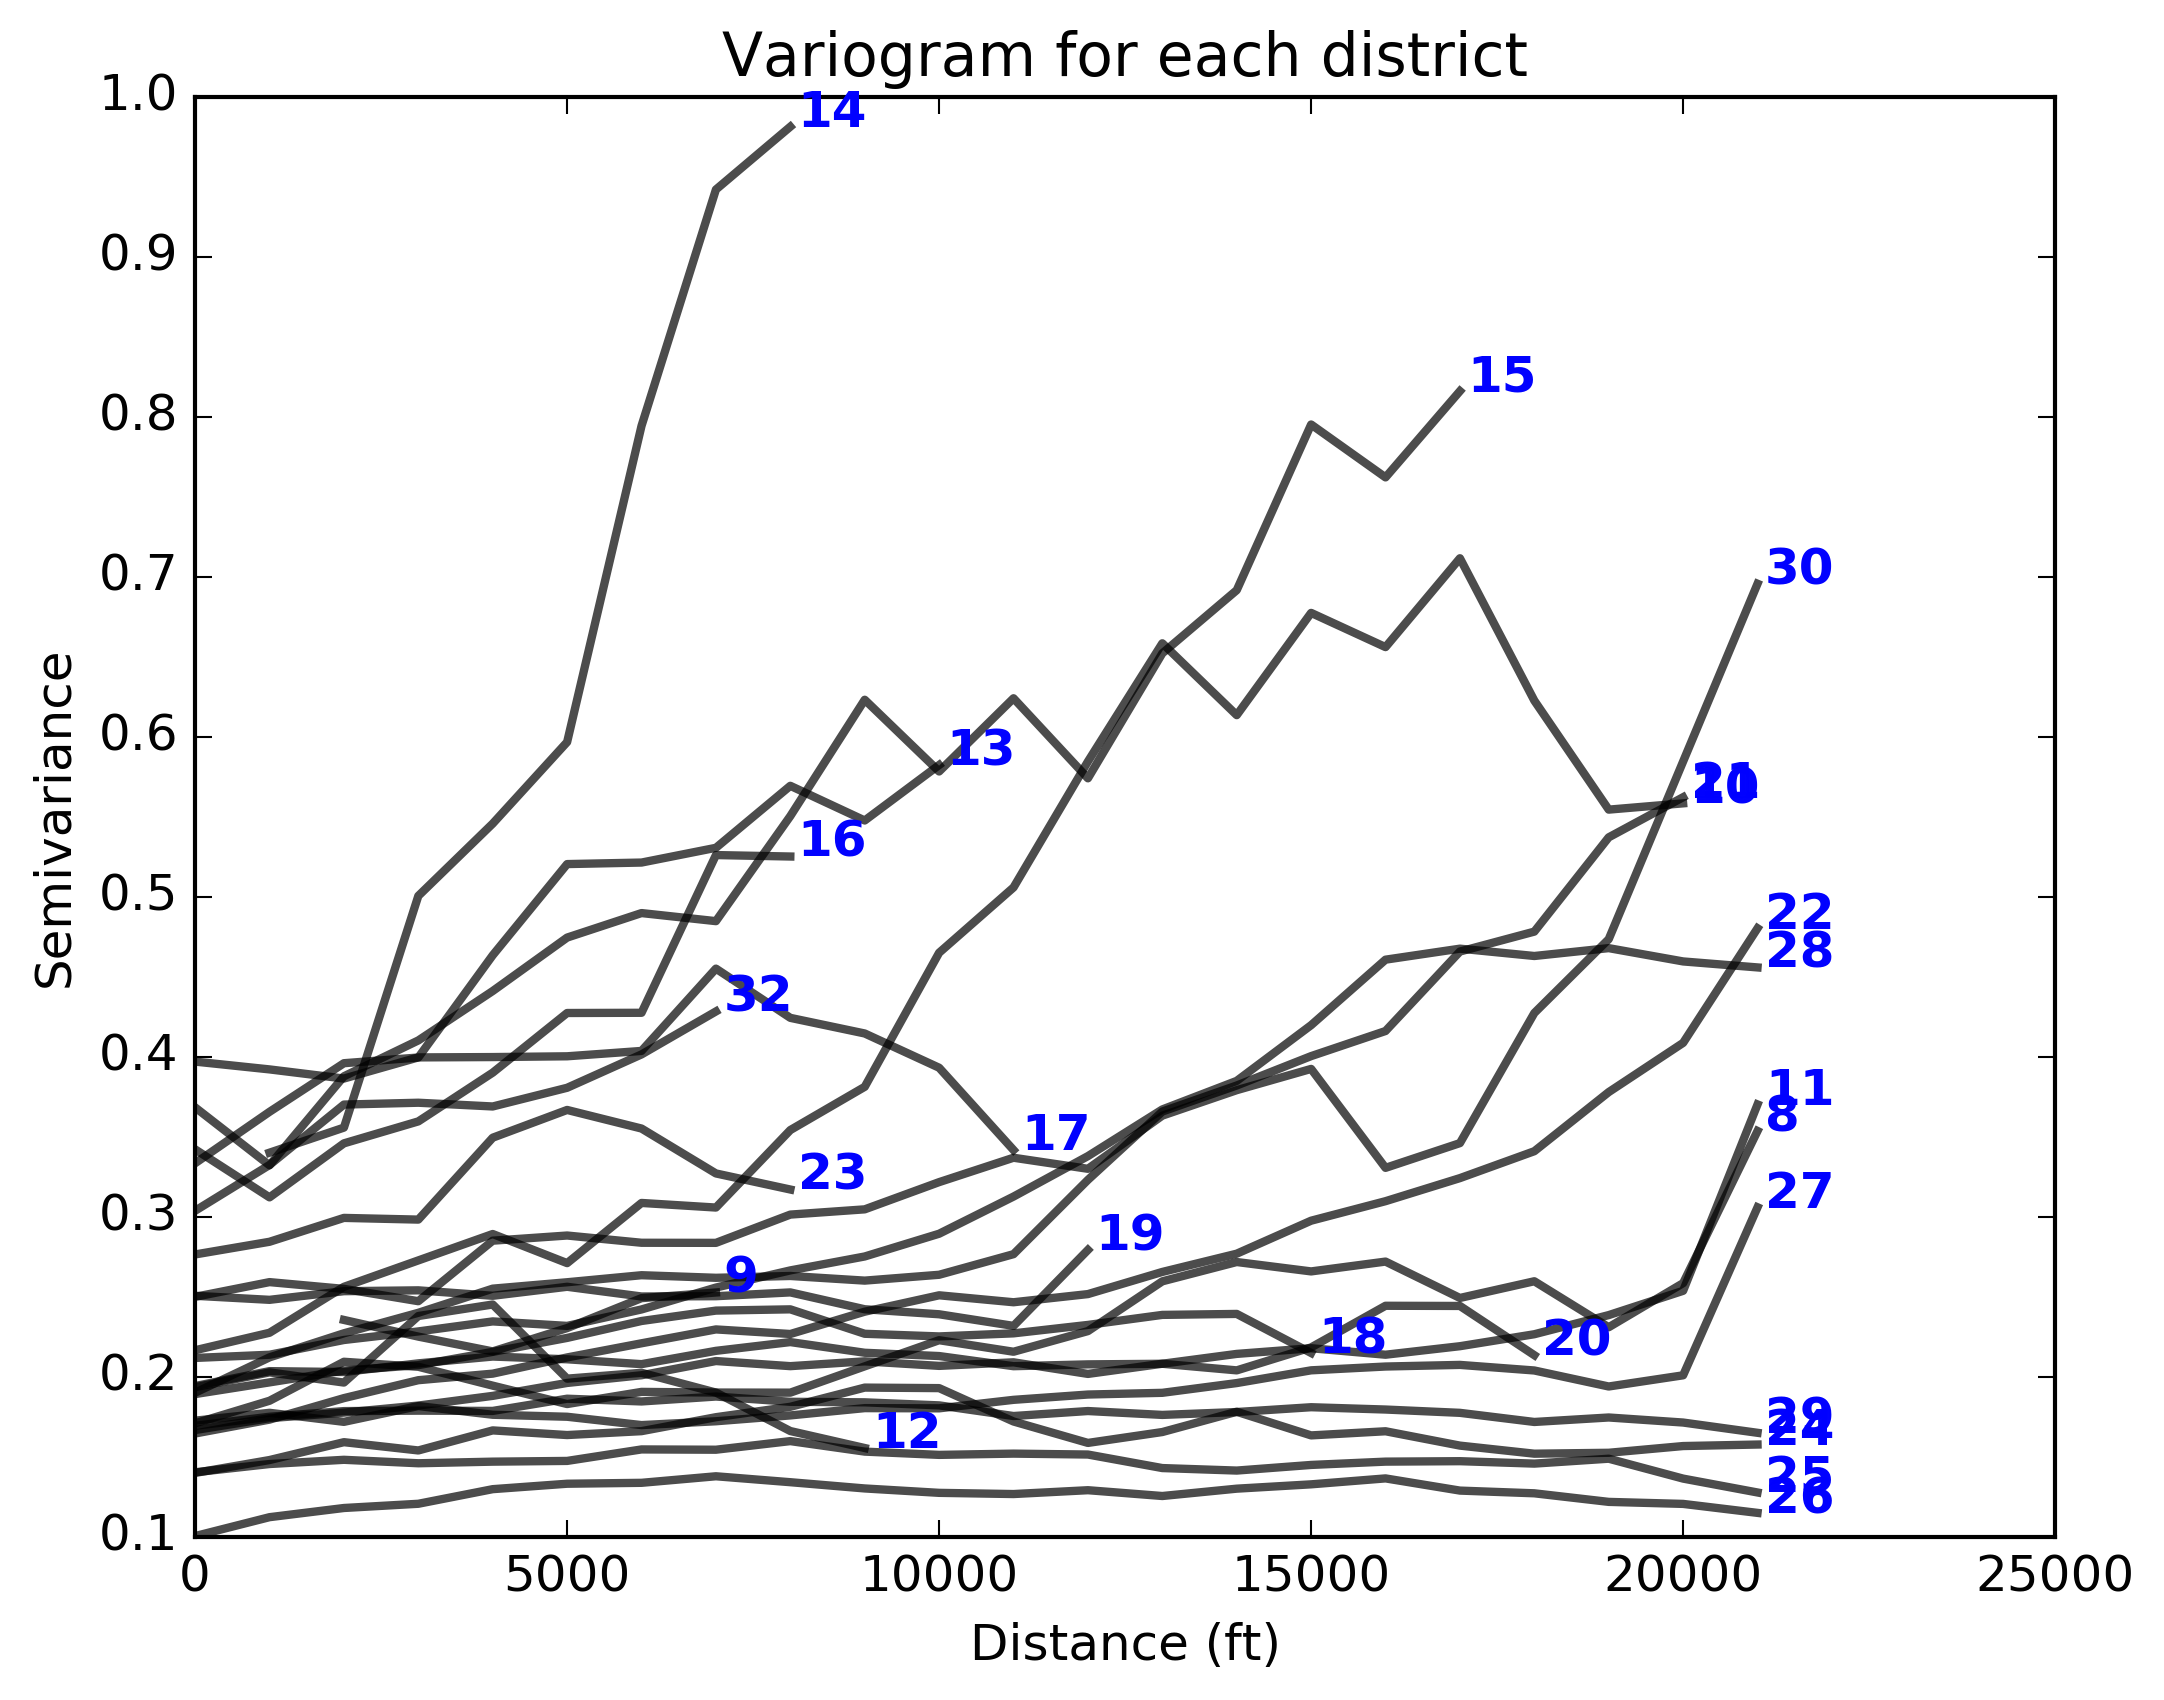

PyObject <matplotlib.text.Text object at 0x326853a90>

In [13]:
for name in schdistrs
    nsales = length(Y_dict[name])
    v = variog_dict[name]
    robust=v.npairs .> 1000
    if sum(robust) == 0
        continue
    end
    lastx = v.bins[robust][end]
    lasty = variog(v)[robust][end]
    plt.plot(v.bins[robust], variog(v)[robust], 
        linewidth=2,
        color="black",
        alpha=0.7,
        label=@sprintf("district %s variogram", name),
        )
    plt.text(lastx+100, lasty, name, color="blue", weight="heavy", family="sans-serif", horizontalalignment="left")
end
plt.ylabel("Semivariance")
plt.xlabel("Distance (ft)")
plt.title("Variogram for each district")
# plt.legend(loc="upper right")

# Fit residuals

In [20]:
import MultivariateStats
mvst=MultivariateStats

MultivariateStats

In [15]:
contrasts_dict = Dict()
for_mm[:SchDistrCat] = categorical(for_mm[:SchDistr])
for (term,col) in eachcol(for_mm)
    DataFrames.is_categorical(col) || continue
    contrasts_dict[term] = DataFrames.FullDummyCoding()
end
mf=DataFrames.ModelFrame(logSalePricePerSQFT ~ BUILDING_CLASS_AT_TIME_OF_SALE+TAX_CLASS_AT_TIME_OF_SALE+BUILDING_CLASS_CATEGORY+SchDistrCat, 
    for_mm, 
    contrasts=contrasts_dict)
mm=ModelMatrix(mf)

ridge_Y = convert(Vector{Float64}, mf.df[:logSalePricePerSQFT])
ridge_coef=mvst.ridge(mm.m, ridge_Y, 10.0, bias=false)

60-element Array{Float64,1}:
  2.63231   
  0.0894669 
  0.0945511 
 -0.00778831
  0.124391  
  0.220948  
  0.136728  
  0.0041111 
  0.283191  
  0.151855  
  0.182136  
  0.38269   
  0.196733  
  ⋮         
  1.65996   
  0.939688  
  0.52438   
  0.285246  
  0.240653  
  0.211328  
 -0.282397  
  0.212216  
  0.229315  
 -0.311034  
 -0.152268  
  0.121362  

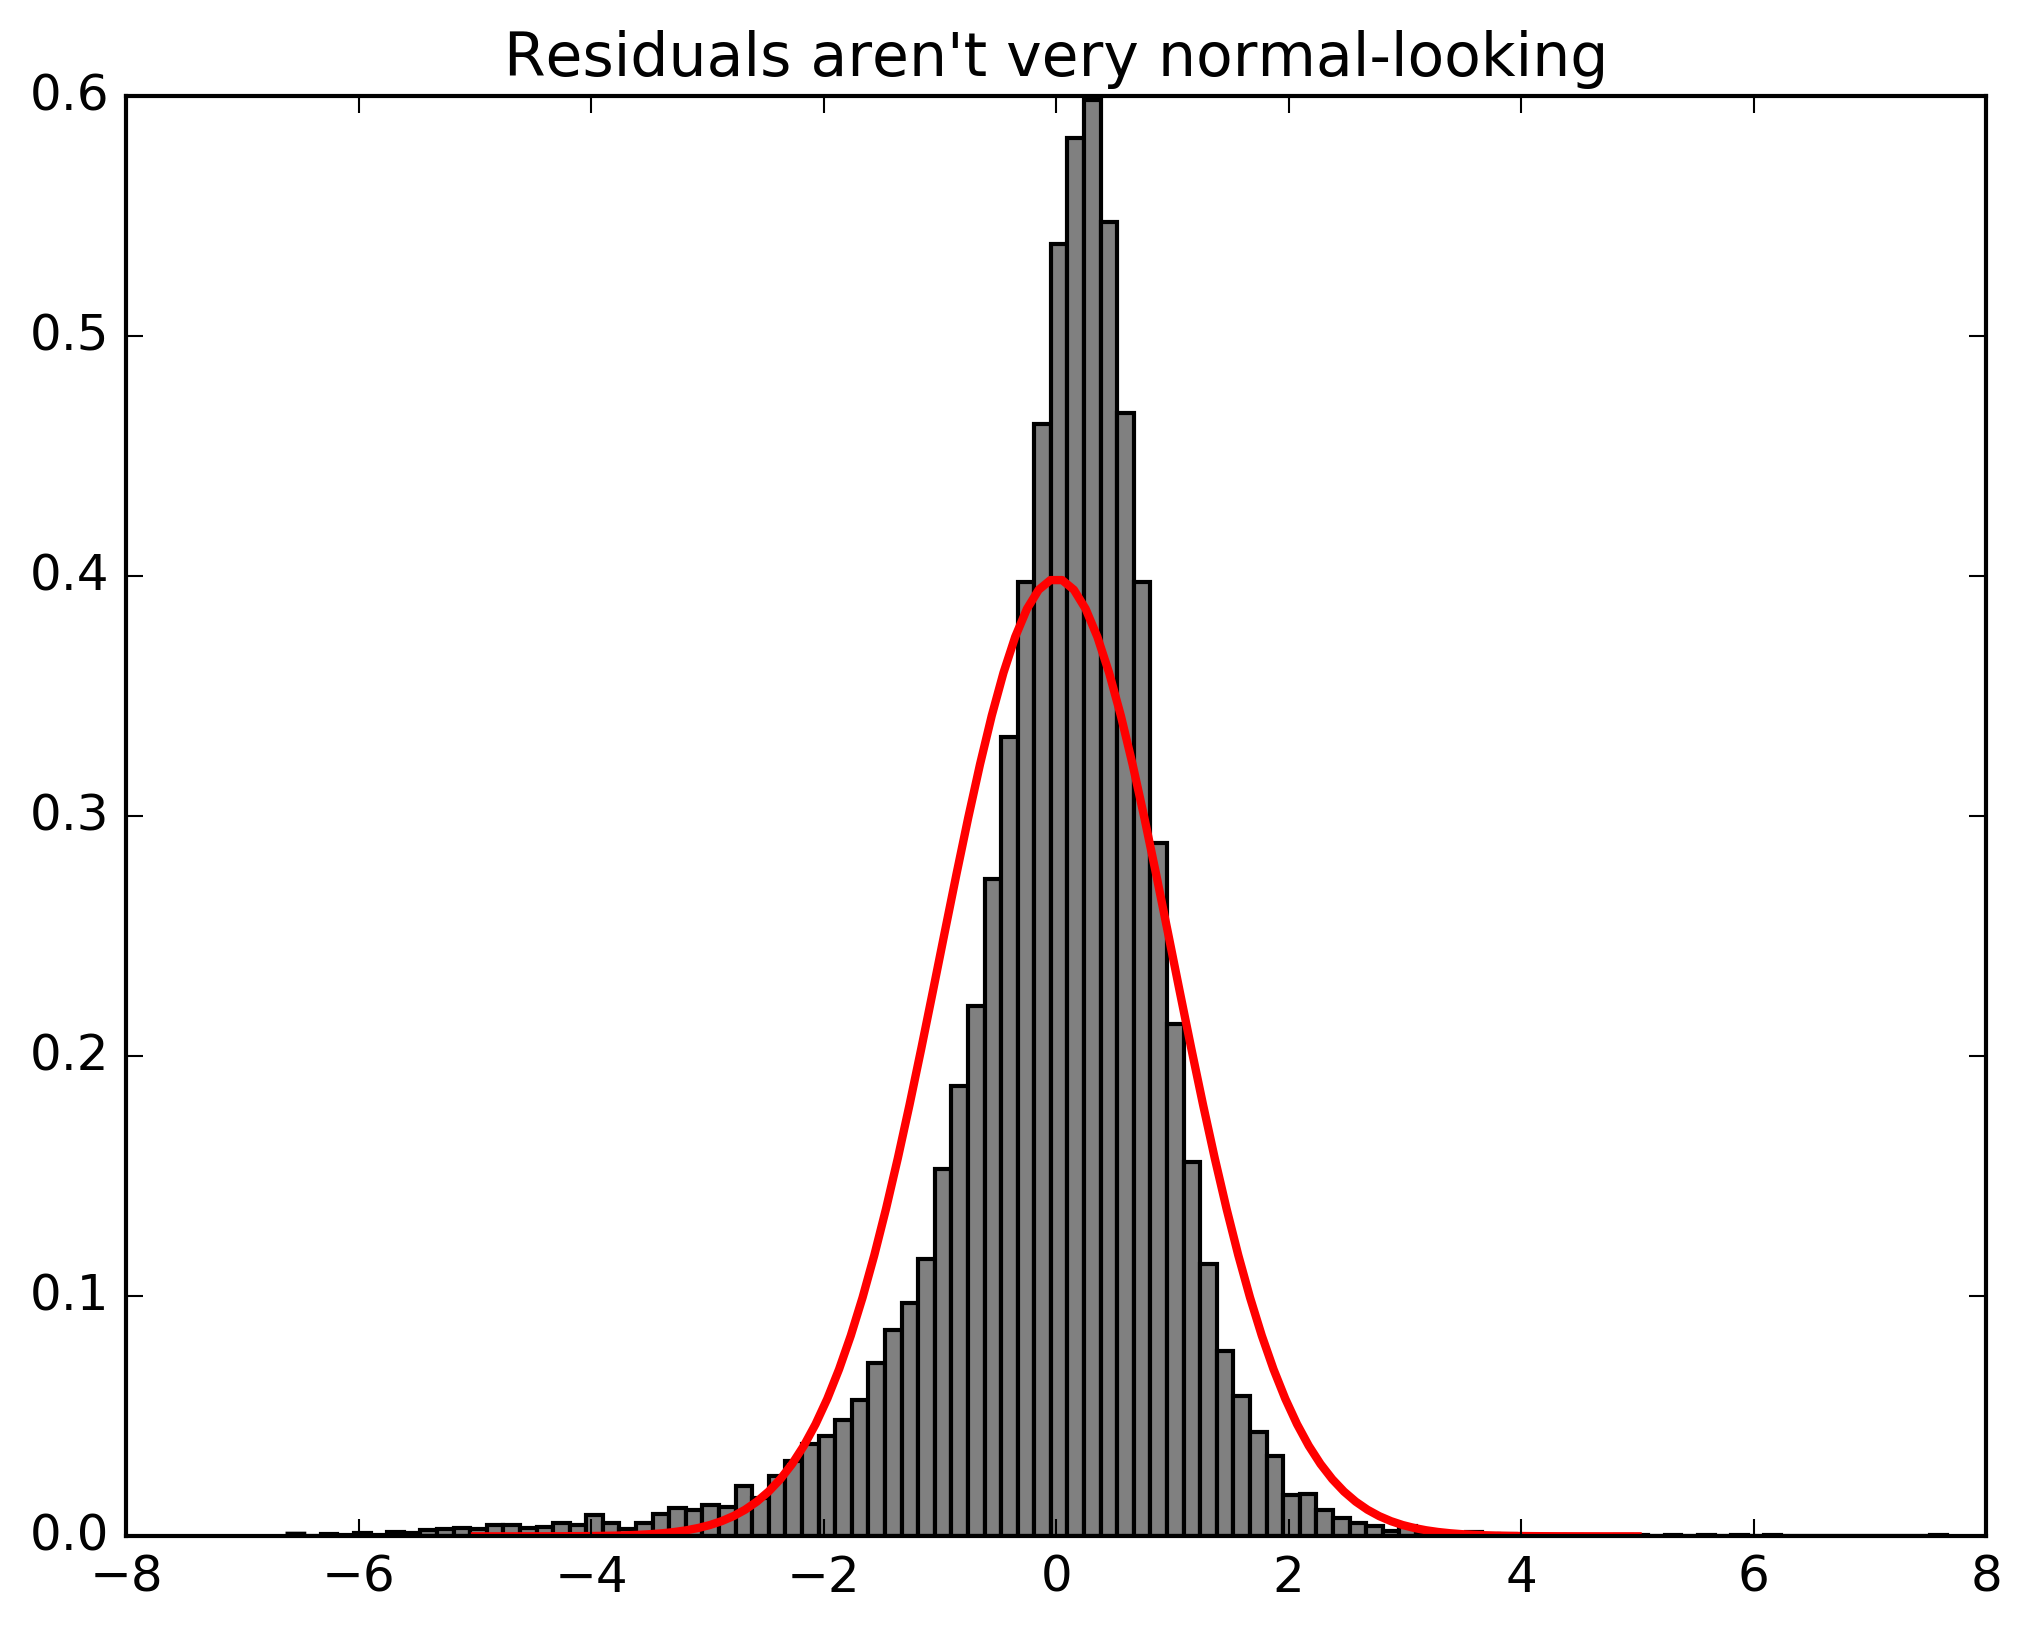

PyObject <matplotlib.text.Text object at 0x32558f450>

In [16]:
ridge_pred = mm.m * ridge_coef
ridge_resid = ridge_Y  .- ridge_pred
plt.plt[:hist](ridge_resid/std(ridge_resid),bins=100, normed=true, color="grey")
plt.plot(linspace(-5,5,100), pdf(Normal(), linspace(-5,5,100)), color="red", linewidth=2)
plt.title("Residuals aren't very normal-looking")

In [17]:
ridge_resid_dict=Dict{String, Vector{Float64}}()
for name in schdistrs
    ridge_resid_dict[name] = ridge_resid[for_mm[:SchDistr].values .== name]
end

In [18]:
resid_variog_dict = Dict{String,Variogram}()
for name in schdistrs
    X = X_dict[name]
    Y = ridge_resid_dict[name]
    v = Variogram(X', Y, histbins)
    resid_variog_dict[name] = v
end

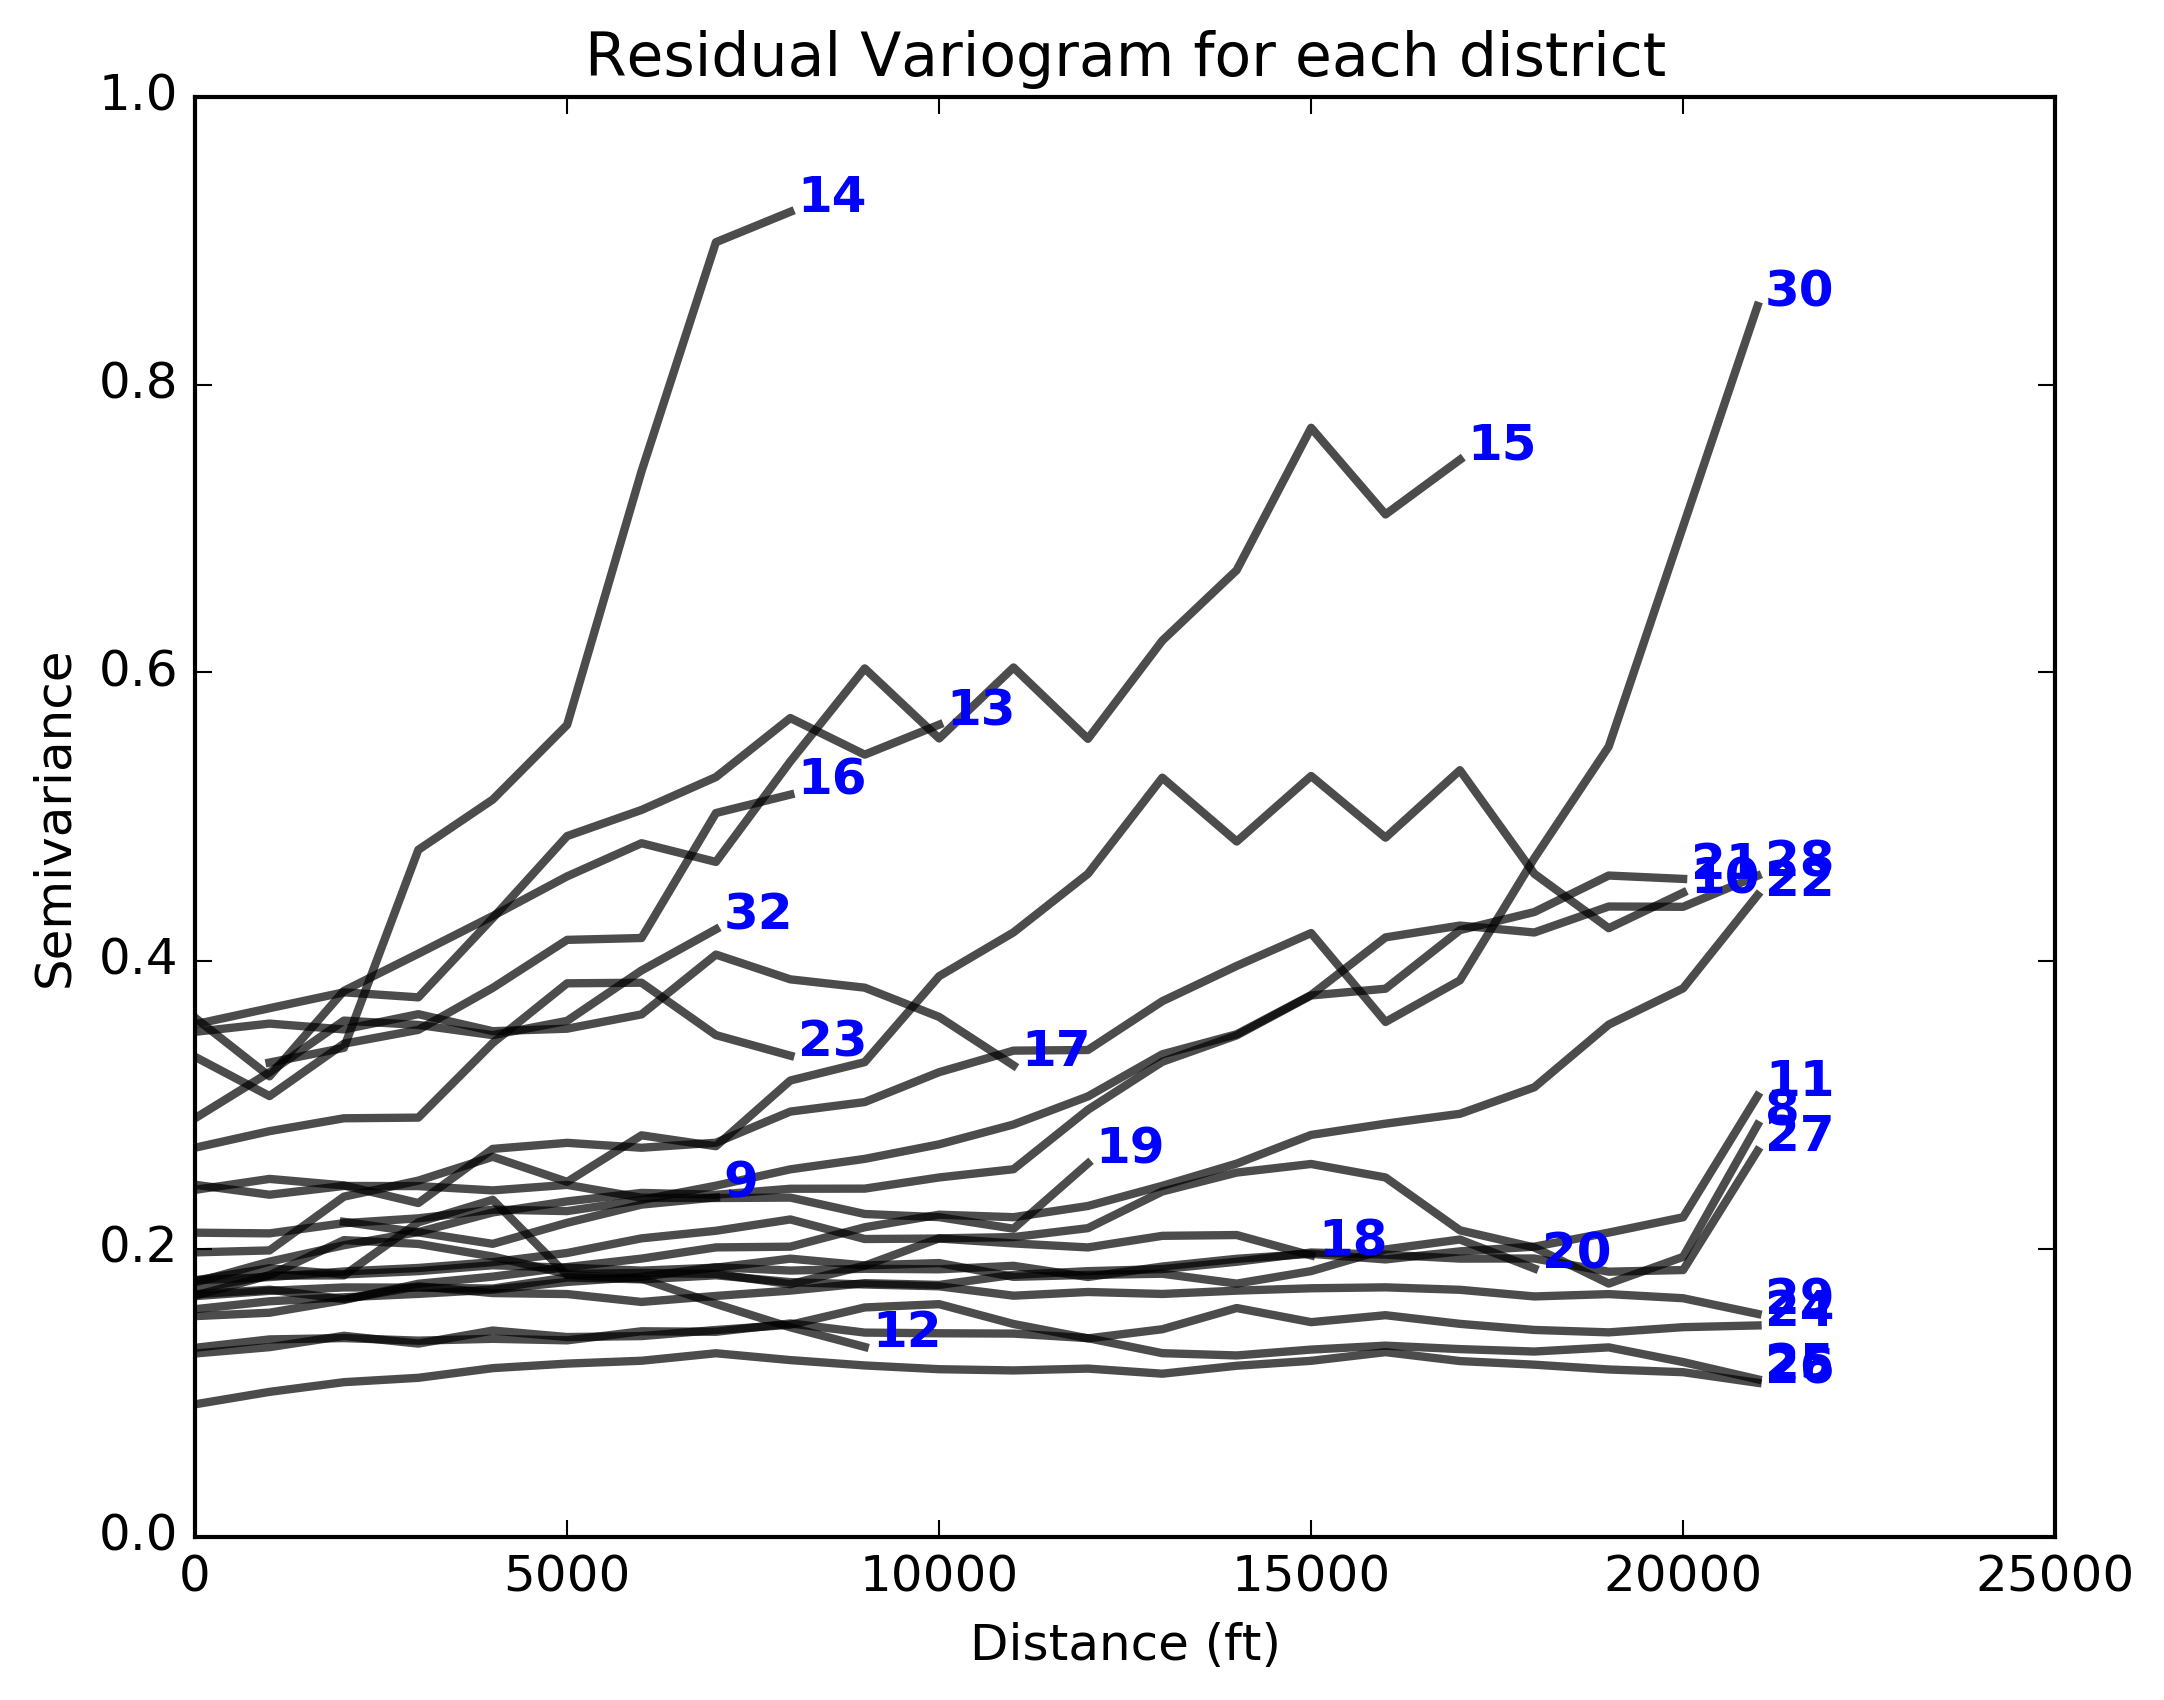

PyObject <matplotlib.text.Text object at 0x3265288d0>

In [19]:
for name in schdistrs
    nsales = length(Y_dict[name])
    v = resid_variog_dict[name]
    robust=v.npairs .> 1000
    if sum(robust) == 0
        continue
    end
    lastx = v.bins[robust][end]
    lasty = variog(v)[robust][end]
    plt.plot(v.bins[robust], variog(v)[robust], 
        linewidth=2,
        color="black",
        alpha=0.7,
        label=@sprintf("district %s variogram", name),
        )
    plt.text(lastx+100, lasty, name, color="blue", weight="heavy", family="sans-serif", horizontalalignment="left")
end
plt.ylabel("Semivariance")
plt.xlabel("Distance (ft)")
plt.title("Residual Variogram for each district")
# plt.legend(loc="upper right")